In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('data/Churn_Modelling.csv')

# Pre-proces

In [3]:
# Define the features and target variable
X = df.drop(['Exited', "RowNumber", "Surname"], axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model

In [6]:
classifier = XGBClassifier(
    colsample_bytree=0.7,
    gamma=10.0,
    learning_rate=0.03,
    max_depth=3,
    n_estimators=215,
    subsample=0.7,
    reg_alpha=3.0,
    reg_lambda=2.0,
    use_label_encoder=False,
    eval_metric='aucpr',
    tree_method='auto',
    random_state=42
)

# Create and fit the pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'RowNumber',
                                                   'CustomerId', 'CreditScore',
                                                   'Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Surname', 'Geography',
                                                   'Gender'])])),
                ('classi...
                               feature_types=None, gamma=10.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.03,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=215, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

# Evaluation

In [7]:
# Predictions and evaluation
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)
train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

In [8]:
# Evaluation
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))
print("Overall Test Accuracy:", accuracy_score(y_test, y_pred))
print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Train ROC-AUC: {train_roc_auc:.4f}, Test ROC-AUC: {test_roc_auc:.4f}")

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1607
           1       0.76      0.43      0.55       393

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.73      2000
weighted avg       0.85      0.86      0.85      2000

Overall Test Accuracy: 0.8615
Train Accuracy: 0.8631, Test Accuracy: 0.8615
Train ROC-AUC: 0.8652, Test ROC-AUC: 0.8644


In [9]:
# Predict probabilities for the training and test sets
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

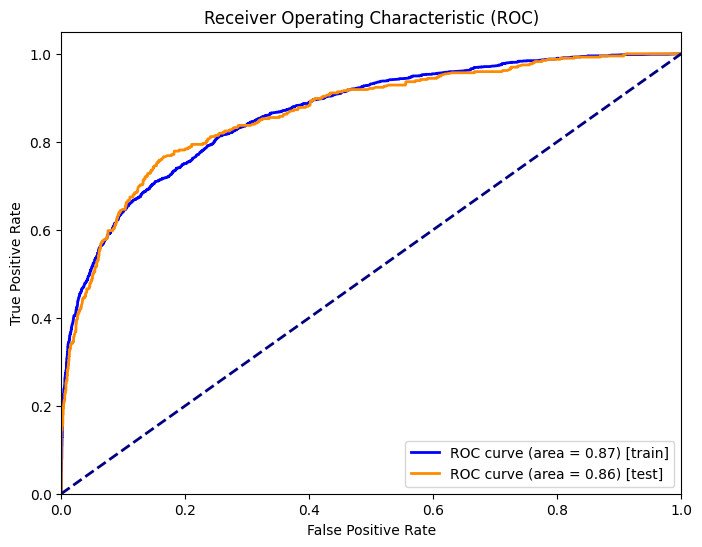

In [10]:
# Compute ROC curve and ROC area for each class
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr_train, tpr_train, color='blue',
         lw=lw, label='ROC curve (area = %0.2f) [train]' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) [test]' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()